In [16]:
'''Trains a simple deep NN on the MNIST dataset.
Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
from keras import backend as k

import matplotlib.pyplot as plt
import numpy as np

batch_size = 128
num_classes = 10
epochs = 5

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

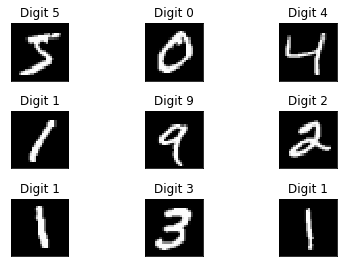

In [3]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Digit {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
y_train.shape

(60000,)

In [7]:
y_test.shape

(10000,)

In [8]:
img_rows , img_cols = 28, 28

In [9]:
k.image_data_format()

'channels_last'

In [10]:
#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if k.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))


In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [13]:
##model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num_classes, activation='softmax'))
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [17]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 14s 226us/step - loss: 0.0891 - acc: 0.9733 - val_loss: 0.0394 - val_acc: 0.9865
Epoch 2/5
60000/60000 [==============================] - 14s 227us/step - loss: 0.0654 - acc: 0.9804 - val_loss: 0.0374 - val_acc: 0.9867
Epoch 3/5
60000/60000 [==============================] - 14s 226us/step - loss: 0.0532 - acc: 0.9844 - val_loss: 0.0319 - val_acc: 0.9891
Epoch 4/5
60000/60000 [==============================] - 14s 226us/step - loss: 0.0442 - acc: 0.9867 - val_loss: 0.0377 - val_acc: 0.9884
Epoch 5/5
60000/60000 [==============================] - 14s 225us/step - loss: 0.0408 - acc: 0.9875 - val_loss: 0.0374 - val_acc: 0.9888


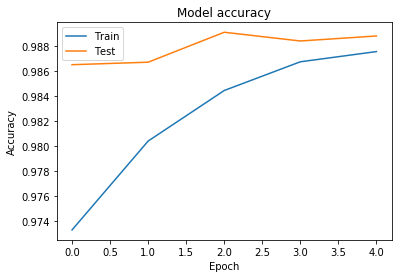

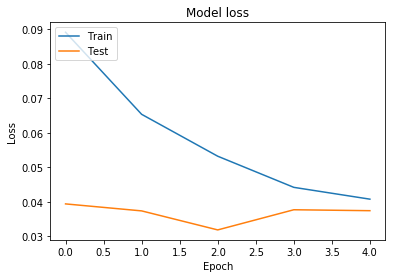

In [18]:
import matplotlib.pyplot as plt 

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [19]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03744168124230928
Test accuracy: 0.9888


In [20]:
# serialize model to JSON
model_digit_json = model.to_json()
with open("mnist_cnn.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("mnist_cnn.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
import shap
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [22]:
e = shap.DeepExplainer(model, background)

C:\Users\Matteo Di Giovinazzo\AppData\Roaming\Python\Python36\site-packages\shap\explainers\deep.py:63: UserWarning: Please keep in mind DeepExplainer is brand new, and we are still developing it and working on characterizing/testing it on large networks. This means you should keep an eye out for odd behavior. Post any issues you run into on github.
  "behavior. Post any issues you run into on github."


In [23]:
shap_values = e.shap_values(X_test[1:5])

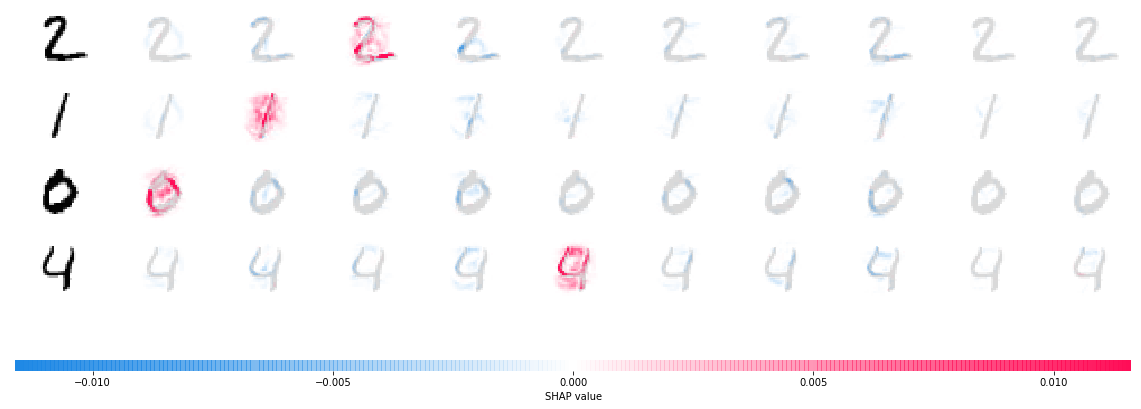

In [24]:
shap.image_plot(shap_values, -X_test[1:5])